#### Investigating the metabolic similarity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
processed_dir = TOP + 'data/processed/'

In [5]:
final_df = pd.read_csv(processed_dir+'final_df_220224.csv', index_col = [0,1])

In [6]:
final_df

struct_sim  alert_sim  metabs_sim  \
Target        Analogue                                             
DTXSID1027269 DTXSID1027269      1.000000        1.0    1.000000   
              DTXSID5026914      1.000000        1.0    0.047619   
              DTXSID4027367      1.000000        1.0    0.061644   
              DTXSID9047596      0.196078        1.0    0.000000   
              DTXSID401036250    0.061224        0.0    0.000000   
...                                   ...        ...         ...   
DTXSID4042254 DTXSID3041877      0.081967        1.0    0.000000   
              DTXSID1024835      0.036364        1.0    0.000000   
              DTXSID1021324      0.025000        1.0    0.000000   
              DTXSID3026514      0.019608        1.0    0.000000   
              DTXSID4042254      1.000000        1.0    1.000000   

                               transformation_sim        WL  phys_sim  Label  
Target        Analogue                                                        
DTXSID1027269 DTXSID1027269              1.000000  1.000000  1.000000    0.0  
              DTXSID5026914              0.866667  0.155979  0.855037    0.0  
              DTXSID4027367              0.866667  0.144200  0.929802    1.0  
              DTXSID9047596              0.000000  0.046260  0.681655    0.0  
              DTXSID401036250            0.150000  0.071651  0.644544    0.0  
...                                           ...       ...       ...    ...  
DTXSID4042254 DTXSID3041877              0.000000  0.140264  0.789391    0.0  
              DTXSID1024835              0.000000  0.110274  0.694941    0.0  
              DTXSID1021324              0.000000  0.000000  0.637881    0.0  
              DTXSID3026514              0.000000  0.025903  0.698762    0.0  
              DTXSID4042254              1.000000  1.000000  1.000000    0.0  

[234278 rows x 7 columns]

In [7]:
y = final_df['Label']

In [8]:
X = final_df.drop(['Label'], axis = 1)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import matthews_corrcoef, roc_auc_score, precision_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [11]:
cv = StratifiedKFold(n_splits = 10)
scorer = make_scorer(balanced_accuracy_score)

In [18]:
X['metabs'] = X[['metabs_sim','transformation_sim','WL']].mean(axis=1)

In [22]:
X.drop(['metabs_sim','transformation_sim','WL'], axis = 1, inplace = True)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = 42)

In [25]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_BA_mean', 'cv_BA_std', 'cv_F1_mean', 'cv_F1_std','cv_MCC_mean','cv_MCC_std','cv_Recall_mean','cv_Recall_std',])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    scorer = {'BA' : make_scorer(balanced_accuracy_score) ,'F1': make_scorer(f1_score), 'MCC' : make_scorer(matthews_corrcoef), 'Recall' : make_scorer(recall_score)}
    cv = StratifiedKFold(n_splits = 10)
    cv_scores = cross_validate(model, train, train_labels, cv = cv, scoring=scorer, n_jobs = -1)
    cv_scores = pd.DataFrame(cv_scores)
    
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_BA_mean': cv_scores['test_BA'].mean(), 
                                                            'cv_BA_std': cv_scores['test_BA'].std(),
                                                          'cv_F1_mean': cv_scores['test_F1'].mean(), 
                                                            'cv_F1_std': cv_scores['test_F1'].std(),
                                                           'cv_MCC_mean': cv_scores['test_MCC'].mean(), 
                                                            'cv_MCC_std': cv_scores['test_MCC'].std(),
                                                           'cv_Recall_mean': cv_scores['test_Recall'].mean(), 
                                                            'cv_Recall_std': cv_scores['test_Recall'].std()
                                                          },
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [26]:
model_results = cv_model(X_train, y_train, LogisticRegression(), 
                         'LR', model_results)

/tmp/ipykernel_1250525/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [27]:
model_results = cv_model(X_train, y_train,
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)


/tmp/ipykernel_1250525/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [28]:
model_results = cv_model(X_train, y_train,
                         RidgeClassifierCV(), 'RIDGE', model_results)

/tmp/ipykernel_1250525/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [29]:
model_results = cv_model(X_train, y_train,
                         RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42), 'RFC', model_results)

/tmp/ipykernel_1250525/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


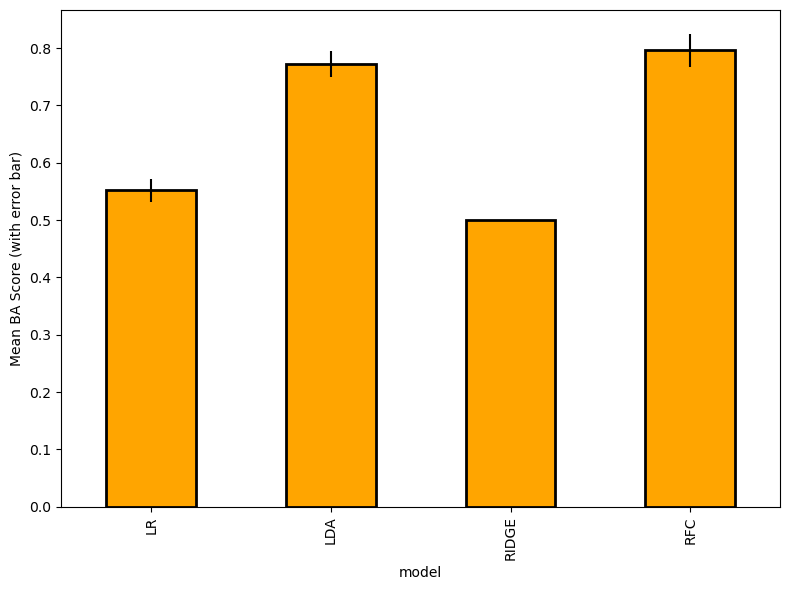

In [30]:
model_results.set_index('model', inplace = True)
model_results['cv_BA_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_BA_std']),
                                  edgecolor = 'k', linewidth = 2)
#plt.title('Model AUC Score Results');
plt.ylabel('Mean BA Score (with error bar)');
model_results.reset_index(inplace = True)
plt.tight_layout()


In [31]:
model_results

,model,cv_BA_mean,cv_BA_std,cv_F1_mean,cv_F1_std,cv_MCC_mean,cv_MCC_std,cv_Recall_mean,cv_Recall_std
0,LR,0.551674,0.019658,0.170507,0.063060,0.224518,0.082524,0.103690,0.039224
1,LDA,0.772431,0.023028,0.241895,0.021231,0.289013,0.024544,0.554265,0.046074
2,RIDGE,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,RFC,0.796053,0.029154,0.720710,0.046981,0.738930,0.041760,0.592257,0.058310


In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
param_grid=dict()
param_grid['solver']=['svd', 'lsqr', 'eigen']

In [37]:
inner_cv = StratifiedKFold(n_splits = 10)
outer_cv = StratifiedKFold(n_splits = 10)

In [38]:
model_to_tune=GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring=make_scorer(balanced_accuracy_score), cv=inner_cv, n_jobs=-1 )

In [39]:
cv_results2 = cross_validate(model_to_tune, X_train, y_train, cv=outer_cv, scoring = make_scorer(balanced_accuracy_score), n_jobs=-1 )

In [40]:
cv_results2['test_score'].mean(), cv_results2['test_score'].std()

(0.7724306733179459, 0.021846421747181117)

In [41]:
model_to_tune.fit(X_train, y_train).best_params_

{'solver': 'svd'}

In [42]:
final_model2 = LinearDiscriminantAnalysis(solver = 'svd')

In [43]:
final_model2.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [44]:
final_model2.coef_

array([[55.94130872,  0.16352803,  0.37078531,  1.61726462]])

In [45]:
final_model2.feature_names_in_.tolist()

['struct_sim', 'alert_sim', 'phys_sim', 'metabs']

In [46]:
final_model2.coef_.tolist()[0]

[55.941308717564496,
 0.16352802545274014,
 0.3707853059393796,
 1.617264618015482]

In [47]:
final_model2.feature_names_in_.T

array(['struct_sim', 'alert_sim', 'phys_sim', 'metabs'], dtype=object)

In [48]:
myco2 = []
for x,y in zip(final_model2.feature_names_in_.tolist(), final_model2.coef_.tolist()[0]):
    myco2.append([x,y])

In [49]:
pd.DataFrame(myco2, columns = ['similarities', 'coefficients'])

,similarities,coefficients
0,struct_sim,55.941309
1,alert_sim,0.163528
2,phys_sim,0.370785
3,metabs,1.617265


In [50]:
preds2 = final_model2.predict(X_test)

In [51]:
balanced_accuracy_score(y_test, preds2)

0.7740225111267449